In [1]:
import sys

sys.path.append("../src")

In [2]:
import importlib
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import MinMaxScaler

import lib
import common
import plotting
import nll_estimation

importlib.reload(lib)

<module 'lib' from '/Users/r/Documents/stud/ss24/finnpinn/news/../src/lib.py'>

In [3]:
CORE_DATA_PLOT_KWARGS = dict(
    alpha=0.5,
    s=4.0,
    color="red",
)


def plot_core_data(axs, **kwargs):
    axs[0].scatter(
        *lib.load_exp_data_numpy("Core 1"), **CORE_DATA_PLOT_KWARGS, **kwargs
    )
    axs[1].scatter(
        *lib.load_exp_data_numpy("Core 2"), **CORE_DATA_PLOT_KWARGS, **kwargs
    )
    axs[2].scatter(
        *lib.load_exp_data_numpy("Core 2B"), **CORE_DATA_PLOT_KWARGS, **kwargs
    )

In [4]:
def get_weighted_interval(samples: np.ndarray, percentile: float, weights=None):
    assert 0 <= percentile <= 1
    if weights is None:
        weights = np.ones(shape=(samples.shape[0]))

    return np.array(
        [
            [
                nll_estimation.weighted_percentile(
                    samples[:, i], weights, (1 - percentile) / 2
                )
                for i in range(samples.shape[1])
            ],
            [
                nll_estimation.weighted_percentile(
                    samples[:, i], weights, (1 + percentile) / 2
                )
                for i in range(samples.shape[1])
            ],
        ]
    )

In [5]:
# DATA_SIGMA = float(
#     np.std(core2_data[1] - np.interp(core2_data[0], t_eval, mean_core2_paper))
# )
DATA_SIGMA = 0.05  # aka. noise tolerance
print(f"{DATA_SIGMA=}")

DATA_SIGMA=0.05


In [6]:
core1_data = lib.load_exp_data_numpy("Core 1")
core2_data = lib.load_exp_data_numpy("Core 2")
core2b_data = lib.load_exp_data_numpy("Core 2b")

# Reproduced MCMC (Barker Sampler) Results

In [7]:
def hists_over_x(samples: np.ndarray, fit_guassians=False, ax=None, **hist_kwargs):
    hist_kwargs.setdefault("bins", 20)
    if ax is None:
        fig, ax = plt.subplots(figsize=(16, 3))

    for k, i in enumerate(
        np.linspace(8, samples.shape[1] - 1, 6, endpoint=True, dtype=int)
    ):
        data = samples[:, i]
        dens, bin_edges = np.histogram(data, **hist_kwargs)
        bin_centers = ((bin_edges[:-1] + bin_edges[1:]) / 2).reshape(-1, 1)
        x_scaler = MinMaxScaler().fit(bin_centers)
        bin_centers = x_scaler.transform(bin_centers)
        bin_centers += k
        ax.plot(bin_centers, dens)

        if fit_guassians:
            loc, scale = stats.norm.fit(data)
            distr = stats.norm(loc, scale)
            x = np.linspace(data.min(), data.max(), 100).reshape(-1, 1)
            std_norm = distr.pdf(x)
            std_norm /= std_norm.max()
            std_norm *= dens.max()
            x = x_scaler.transform(x)
            x += k
            ax.plot(x, std_norm, "k--")

    return plt.gcf(), ax

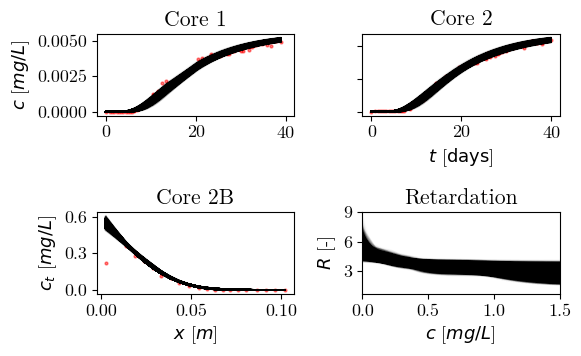

In [8]:
mcmc_samples = lib.ExperimentalSamples.from_dir("../data_processed/experimental/MCMC/")
# mcmc_samples.core1 = mcmc_samples.core1[:100]
# mcmc_samples.core2 = mcmc_samples.core2[:100]
# mcmc_samples.core2b = mcmc_samples.core2b[:100]
# mcmc_samples.ret_y = mcmc_samples.ret_y[:100]
# shuffle_indices = np.arange(mcmc_samples.ret_y.shape[0])
# np.random.shuffle(shuffle_indices)
# mcmc_samples.core2 = mcmc_samples.core2[shuffle_indices]
# mcmc_samples.ret_y = mcmc_samples.ret_y[shuffle_indices]

fig, axs = mcmc_samples.plot()

plot_core_data(axs)
# axs[1].plot(core2_data[0], np.median(mcmc_samples.core2, axis=0), "-", color="C0")


plt.tight_layout()
plotting.savefig(fig, "../paper/figs/finn_mcmc_samples")
plt.show()

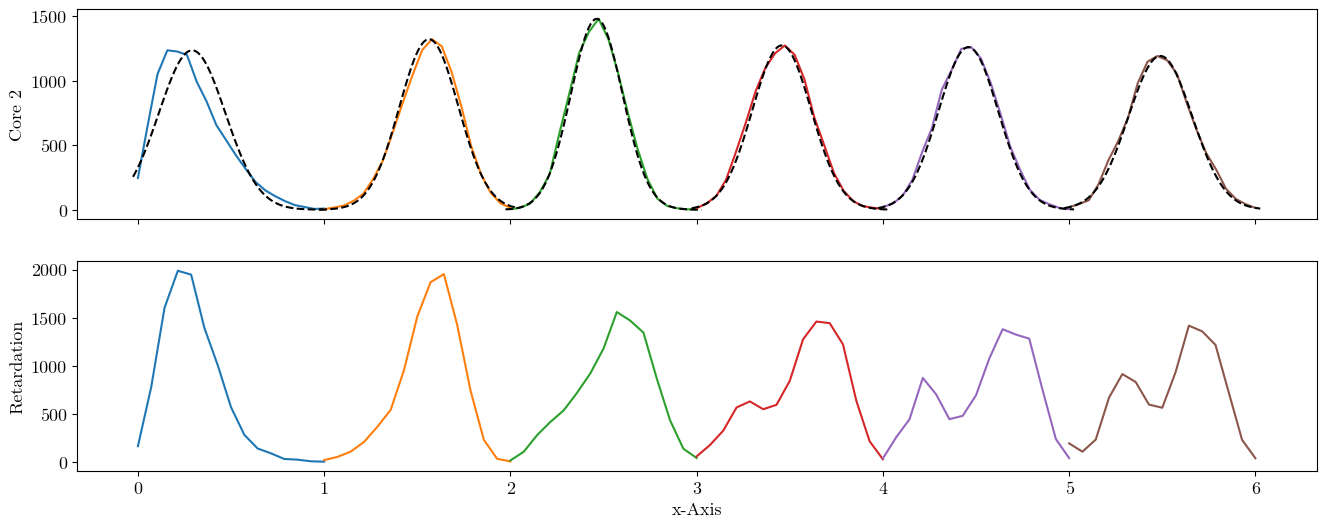

In [9]:
fig, axs = plt.subplots(nrows=2, figsize=(16, 6), sharex=True)
axs[0].set_ylabel("Core 2")
axs[1].set_ylabel("Retardation")
axs[1].set_xlabel("x-Axis")
hists_over_x(mcmc_samples.core2, ax=axs[0], fit_guassians=True)
hists_over_x(mcmc_samples.ret_y, ax=axs[1], fit_guassians=False, bins=15)
plt.show()

## Comparison with paper PI

In [10]:
PI_PLOT_KWARGS = dict(
    alpha=0.3,
    edgecolor="none",
    zorder=-10,
)

In [11]:
upper_my_mcmc_ret_90 = np.quantile(mcmc_samples.ret_y, 0.95, axis=0)
lower_my_mcmc_ret_90 = np.quantile(mcmc_samples.ret_y, 0.05, axis=0)
upper_my_mcmc_core2_90 = np.quantile(mcmc_samples.core2, 0.95, axis=0)
lower_my_mcmc_core2_90 = np.quantile(mcmc_samples.core2, 0.05, axis=0)

In [12]:
_, _, upper_mcmc_PI_core2, lower_mcmc_PI_core2, u_data, _, _, _ = (
    common.load_mcmc_paper_curves(t_eval=core2_data[0])
)

n_inside_my = np.count_nonzero(
    (core2_data[1] <= upper_my_mcmc_core2_90)
    & (core2_data[1] >= lower_my_mcmc_core2_90)
)
n_inside_his = np.count_nonzero(
    (core2_data[1] <= upper_mcmc_PI_core2) & (core2_data[1] >= lower_mcmc_PI_core2)
)

print(f" My Core 2 PI contains: {n_inside_my/len(core2_data[1]):.1%}")
print(f"His Core 2 PI contains: {n_inside_his/len(core2_data[1]):.1%}")

 My Core 2 PI contains: 54.5%
His Core 2 PI contains: 78.2%


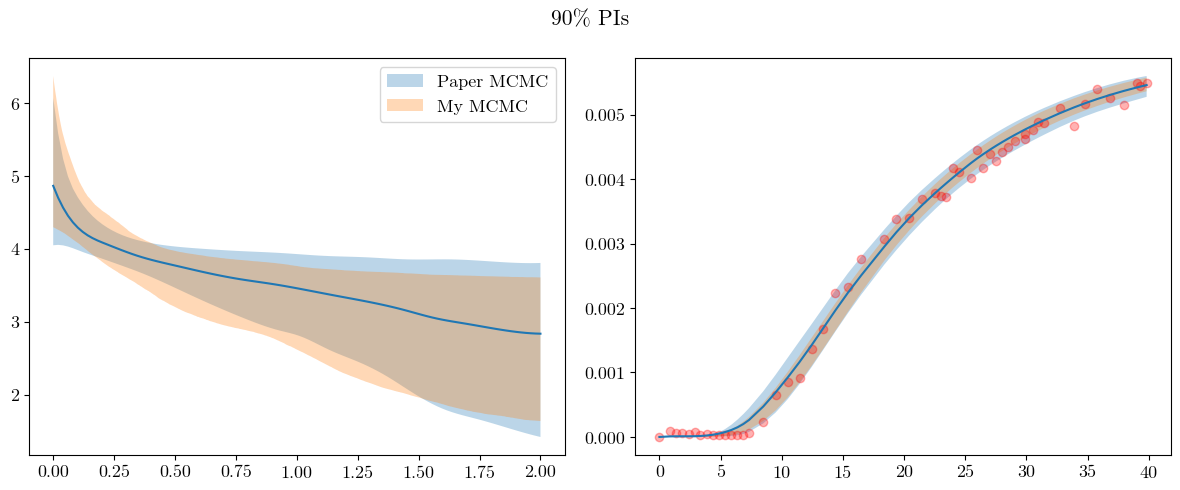

In [13]:
(
    t_eval,
    mean_core2_paper,
    upper_mcmc_PI_core2,
    lower_mcmc_PI_core2,
    u_eval,
    mean_ret_core2_paper,
    upper_ret_mcmc_PI_core2_paper,
    lower_ret_mcmc_PI_core2_paper,
) = common.load_mcmc_paper_curves(t_eval=lib.load_exp_data_numpy("Core 2")[0])
paper_mcmc_samples = lib.ExperimentalSamples(
    core1=(None, None),
    core2=np.array([upper_mcmc_PI_core2, lower_mcmc_PI_core2]),
    core2b=(None, None),
    ret_x=u_eval,
    ret_y=np.array([upper_ret_mcmc_PI_core2_paper, lower_ret_mcmc_PI_core2_paper]),
)

fig, axs = plt.subplots(ncols=2, figsize=(12, 5))
fig.suptitle("90% PIs")
axs[0].plot(u_eval, mean_ret_core2_paper, "-", color="C0")
axs[0].fill_between(
    u_eval,
    lower_ret_mcmc_PI_core2_paper,
    upper_ret_mcmc_PI_core2_paper,
    color="C0",
    **PI_PLOT_KWARGS,
    label="Paper MCMC",
)
axs[0].fill_between(
    mcmc_samples.ret_x,
    lower_my_mcmc_ret_90,
    upper_my_mcmc_ret_90,
    color="C1",
    **PI_PLOT_KWARGS,
    label="My MCMC",
)
axs[0].legend()

axs[1].scatter(*core2_data, color="red", alpha=0.3)
axs[1].plot(t_eval, mean_core2_paper, "-", color="C0")
axs[1].fill_between(
    t_eval,
    lower_mcmc_PI_core2,
    upper_mcmc_PI_core2,
    color="C0",
    **PI_PLOT_KWARGS,
    label="Paper MCMC",
)
axs[1].fill_between(
    core2_data[0],
    lower_my_mcmc_core2_90,
    upper_my_mcmc_core2_90,
    color="C1",
    **PI_PLOT_KWARGS,
    label="My MCMC",
)
plt.tight_layout()
plt.show()

# SPAN on Core 2 Data

## SPAN

np.std(span_weights)=5.957136635429415e-08


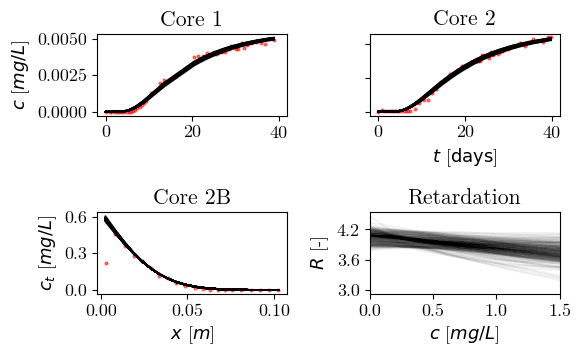

In [14]:
processed_expdata_dir = Path("../data_processed/experimental/SPAN")

span_samples = lib.ExperimentalSamples.from_dir(processed_expdata_dir)
span_weights = nll_estimation.compute_hist_weights(
    core2_data[1],
    span_samples.core2,
    sigma=DATA_SIGMA,
)
print(f"{np.std(span_weights)=}")

span_core1_PI_90 = get_weighted_interval(span_samples.core1, 0.9, weights=span_weights)
span_core2_PI_90 = get_weighted_interval(span_samples.core2, 0.9, weights=span_weights)
span_core2b_PI_90 = get_weighted_interval(
    span_samples.core2b, 0.9, weights=span_weights
)
span_ret_PI_90 = get_weighted_interval(span_samples.ret_y, 0.9, weights=span_weights)

fig, axs = span_samples.plot()

plot_core_data(axs)

# axs[0].fill_between(core1_data[0], *span_core1_PI_90, color="C0", alpha=0.5, zorder=100)
# axs[1].fill_between(core2_data[0], *span_core2_PI_90, color="C0", alpha=0.5, zorder=100)
# axs[2].fill_between(
#     core2b_data[0], *span_core2b_PI_90, color="C0", alpha=0.5, zorder=100
# )
# axs[3].fill_between(
#     span_samples.ret_x, *span_ret_PI_90, color="C0", alpha=0.5, zorder=100
# )

plt.tight_layout()
plotting.savefig(fig, "../paper/figs/finn_span_samples")
plt.show()

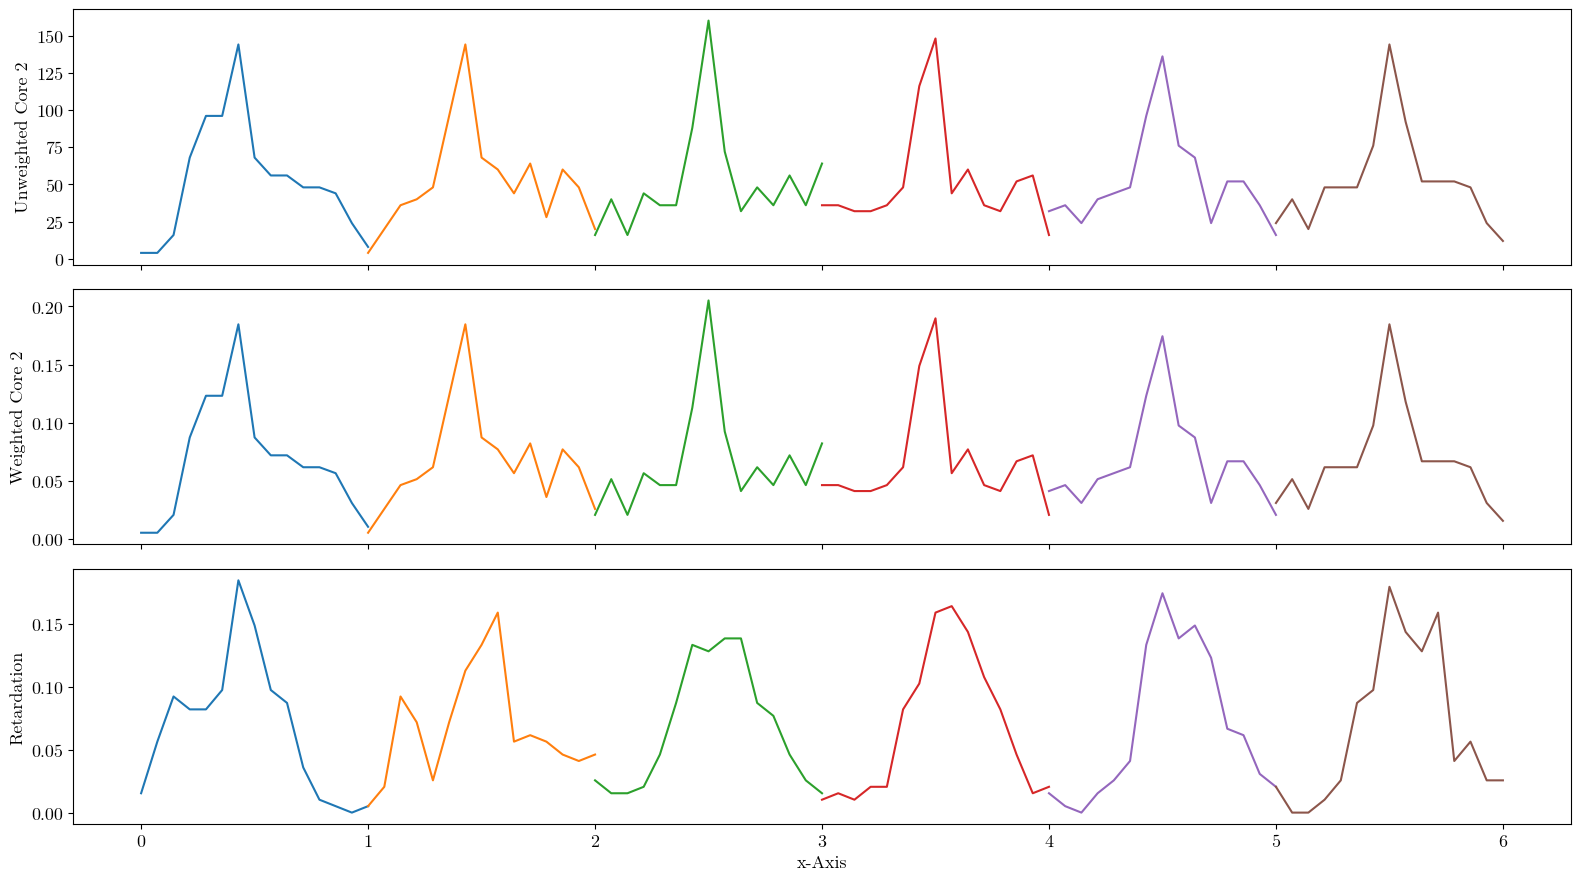

In [15]:
fig, axs = plt.subplots(nrows=3, figsize=(16, 9), sharex=True)
axs[0].set_ylabel("Unweighted Core 2")
axs[1].set_ylabel("Weighted Core 2")
axs[2].set_ylabel("Retardation")
axs[-1].set_xlabel("x-Axis")
hist_kwargs = dict(fit_guassians=False, bins=15)
hists_over_x(span_samples.core2, ax=axs[0], **hist_kwargs)
hists_over_x(span_samples.core2, ax=axs[1], weights=span_weights, **hist_kwargs)
hists_over_x(span_samples.ret_y, ax=axs[2], weights=span_weights, **hist_kwargs)
plt.tight_layout()
plt.show()

In [16]:
# just to check if both functions do about the same thing...
print(nll_estimation.weighted_percentile(span_samples.ret_y[:, 20], span_weights, 0.05))
print(nll_estimation.compute_PI(span_samples.ret_y[:, 20], span_weights, 0.05))

3.866305
3.8749068


## PI3NN-SPAN (or better name Data-SPAN?)

### Subsets

In [17]:
# fig, axs = plt.subplots(
#     ncols=2, nrows=3, figsize=(2 * plotting.FIGURE_WIDTH, 3 * plotting.FIGURE_HEIGHT), sharex=True, sharey=True,
# )

# rng = np.random.default_rng()


# for col, thingy_samples in enumerate(
#     [
#         lib.ExperimentalSamples.from_dir(
#             Path("../data_processed/experimental/DataSPAN")
#         ),
#         lib.ExperimentalSamples.from_dir("../data_processed/experimental/MCMC/"),
#     ]
# ):
#     n_original = thingy_samples.ret_y.shape[0]

#     for row in range(3):
#         thingy_samples.ret_y = rng.choice(thingy_samples.ret_y, 70)
#         for ret_y in thingy_samples.ret_y:
#             axs[row, col].plot(thingy_samples.ret_x, ret_y, "k-", alpha=0.1)


# axs[0,0].set_title("Data-SPAN")
# axs[0,1].set_title("MCMC")

# plt.tight_layout()
# # plotting.savefig(fig, "../paper/figs/finn_dataspan_subset_PIs")
# plt.show()

### Full

dataspan_samples.core2.shape=(69, 55)
np.std(dataspan_weights)=2.1535465375723075e-06


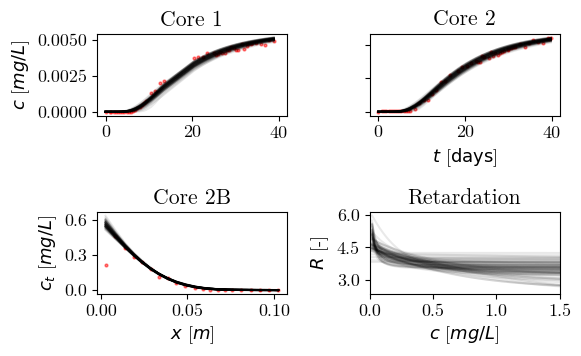

In [18]:
dataspan_samples = lib.ExperimentalSamples.from_dir(
    Path("../data_processed/experimental/DataSPAN")
)
print(f"{dataspan_samples.core2.shape=}")
fig, axs = dataspan_samples.plot()

plot_core_data(axs)


# weighting =========================
dataspan_weights = nll_estimation.compute_hist_weights(
    core2_data[1],
    dataspan_samples.core2,
    sigma=DATA_SIGMA,
)
print(f"{np.std(dataspan_weights)=}")

dataspan_core1_PI_90 = get_weighted_interval(
    dataspan_samples.core1, 0.9, weights=dataspan_weights
)
dataspan_core2_PI_90 = get_weighted_interval(
    dataspan_samples.core2, 0.9, weights=dataspan_weights
)
dataspan_core2b_PI_90 = get_weighted_interval(
    dataspan_samples.core2b, 0.9, weights=dataspan_weights
)
dataspan_ret_PI_90 = get_weighted_interval(
    dataspan_samples.ret_y, 0.9, weights=dataspan_weights
)


# axs[0].fill_between(
#     core1_data[0], *dataspan_core1_PI_90, color="C0", alpha=0.5, zorder=100
# )
# axs[1].fill_between(
#     core2_data[0], *dataspan_core2_PI_90, color="C0", alpha=0.5, zorder=100
# )
# axs[2].fill_between(
#     core2b_data[0], *dataspan_core2b_PI_90, color="C0", alpha=0.5, zorder=100
# )
# axs[3].fill_between(
#     dataspan_samples.ret_x, *dataspan_ret_PI_90, color="C0", alpha=0.5, zorder=100
# )
# ===================================


plt.tight_layout()
plotting.savefig(fig, "../paper/figs/finn_dataspan_samples")
plt.show()

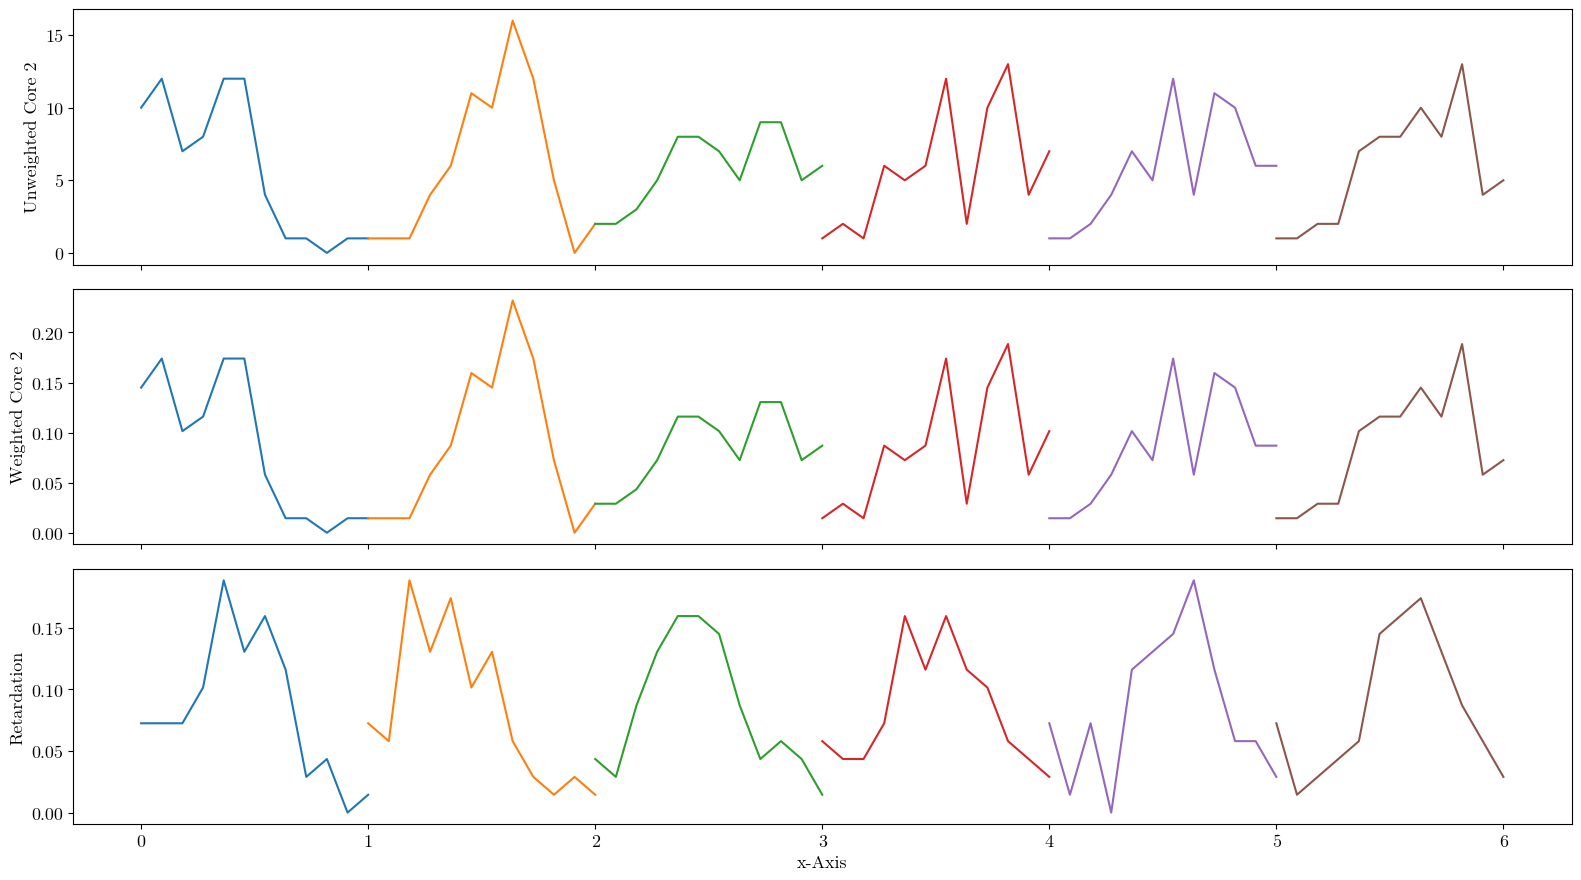

In [19]:
fig, axs = plt.subplots(nrows=3, figsize=(16, 9), sharex=True)
axs[0].set_ylabel("Unweighted Core 2")
axs[1].set_ylabel("Weighted Core 2")
axs[2].set_ylabel("Retardation")
axs[-1].set_xlabel("x-Axis")
hist_kwargs = dict(fit_guassians=False, bins=12)
hists_over_x(dataspan_samples.core2, ax=axs[0], **hist_kwargs)
hists_over_x(dataspan_samples.core2, ax=axs[1], weights=dataspan_weights, **hist_kwargs)
hists_over_x(dataspan_samples.ret_y, ax=axs[2], weights=dataspan_weights, **hist_kwargs)
plt.tight_layout()
plt.show()

## Data-SPAN + SPAN

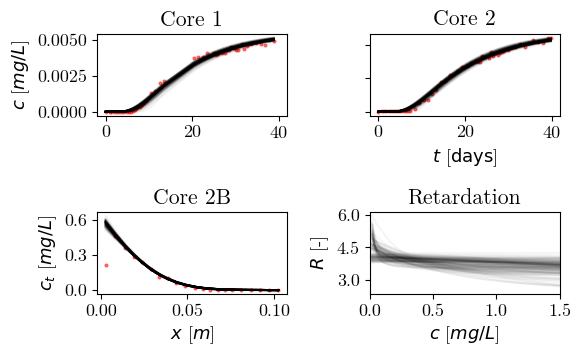

In [43]:
STEP = 10  # temporary fix, see readme on how to do it properly
downsampled_span_ret_samples = np.array(
    [
        np.interp(dataspan_samples.ret_x, span_samples.ret_x, span_samples.ret_y[i, :])
        for i in range(0, span_samples.ret_y.shape[1], STEP)
    ]
)
fullspan_samples = lib.ExperimentalSamples(
    core1=np.concatenate([dataspan_samples.core1, span_samples.core1[::STEP]]),
    core2=np.concatenate([dataspan_samples.core2, span_samples.core2[::STEP]]),
    core2b=np.concatenate([dataspan_samples.core2b, span_samples.core2b[::STEP]]),
    ret_y=np.concatenate([dataspan_samples.ret_y, downsampled_span_ret_samples]),
    ret_x=dataspan_samples.ret_x,
)

fullspan_weights = nll_estimation.compute_hist_weights(
    core2_data[1],
    fullspan_samples.core2,
    sigma=DATA_SIGMA,
)

fig, axs = fullspan_samples.plot()

plot_core_data(axs)

plt.tight_layout()
plotting.savefig(fig, "../paper/figs/finn_fullspan_samples")
plt.show()

# Comparisons

In [21]:
from matplotlib.lines import Line2D

# # Plotting the samples
# mcmc_samples.plot(axs, line_kwargs=dict(alpha=0.2, color="C1"), only_outlines=True)
# span_samples.plot(axs, line_kwargs=dict(alpha=0.2, color="C2"), only_outlines=True)

# # Creating proxy artists for legend
# legend_elements = [
#     Line2D([0], [0], color="C1", label="MCMC Samples"),
#     Line2D([0], [0], color="C2", label="SPAN Samples"),
# ]

# # Adding the legend to the figure (or specify an axis if preferred)
# fig.legend(handles=legend_elements, loc="upper center", ncol=2, fontsize="medium")

# plt.tight_layout()
# plt.show()

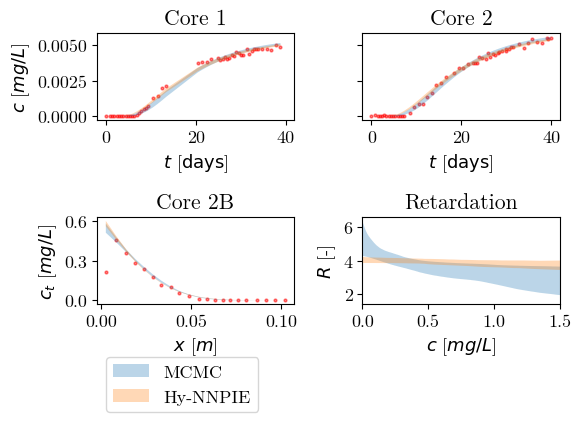

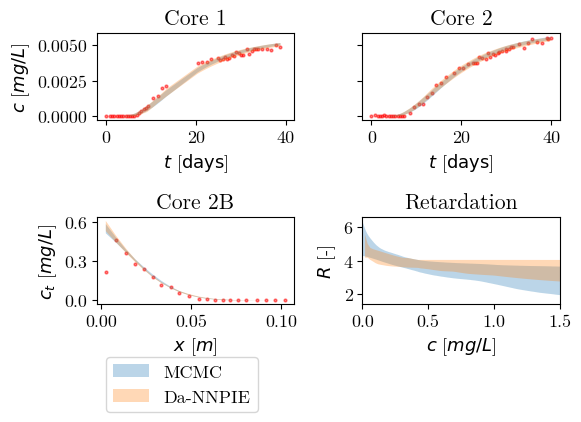

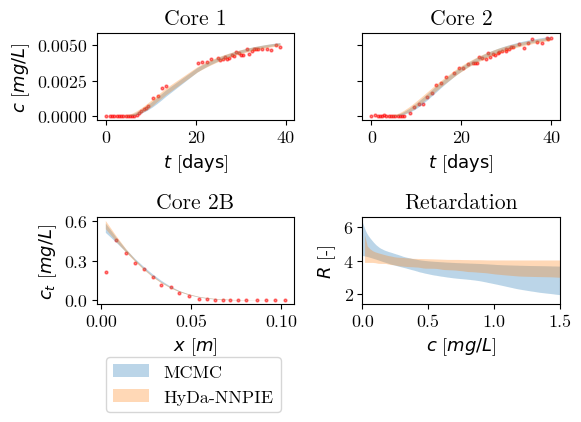

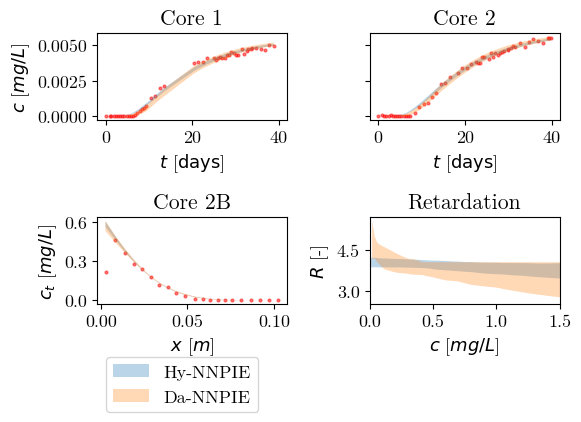

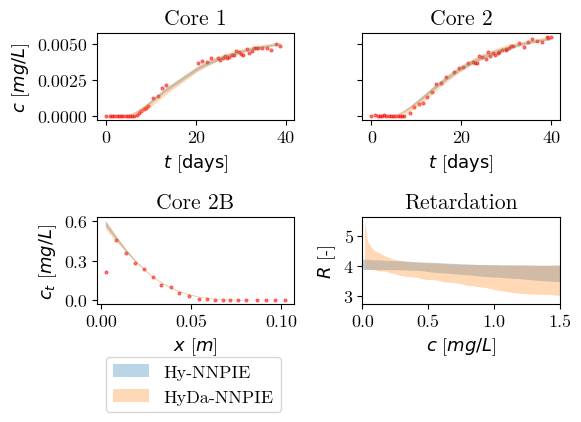

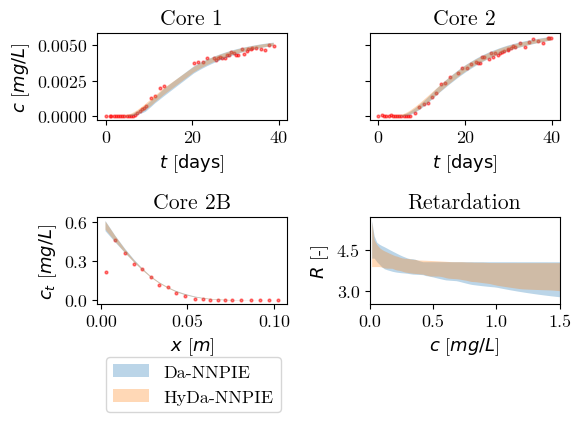

In [44]:
import itertools
from typing import Optional

import matplotlib.pyplot as plt

USED_QUANTILE = 0.9  # Paper says it uses 95%, but the code shows 90%.
assert USED_QUANTILE == 0.9


def upper_lower_from_name(
    samples: lib.ExperimentalSamples, name: str, attr_name: str
) -> tuple[Optional[np.ndarray], Optional[np.ndarray]]:
    if name in ["Da-NNPIE", "Hy-NNPIE", "HyDa-NNPIE"]:
        # These two should in theory cover the whole distribution, thus I compute the quantiles
        weights = {
            "Da-NNPIE": dataspan_weights,
            "Hy-NNPIE": span_weights,
            "HyDa-NNPIE": fullspan_weights,
        }[name]
        lower, upper = get_weighted_interval(
            getattr(samples, attr_name), USED_QUANTILE, weights
        )
    elif name == "Paper MCMC":
        upper, lower = getattr(samples, attr_name)
    elif name == "MCMC":
        # if attr_name in ["core1", "core2b"]:
        #     upper, lower = None, None  # TODO: Compute the samples for core1 and core2b
        # else:
        upper = np.quantile(
            getattr(samples, attr_name), (1 + USED_QUANTILE) / 2, axis=0
        )
        lower = np.quantile(
            getattr(samples, attr_name), (1 - USED_QUANTILE) / 2, axis=0
        )
    else:
        raise ValueError(f"Unknown method '{name}'")
    return upper, lower


methods = [
    (mcmc_samples, "MCMC"),
    # (paper_mcmc_samples, "Paper MCMC"),
    (span_samples, "Hy-NNPIE"),
    (dataspan_samples, "Da-NNPIE"),
    (fullspan_samples, "HyDa-NNPIE"),  # TODO: uncomment once these are properly generated
]
for method1, method2 in itertools.combinations(methods, 2):
    fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(2*plotting.FIGURE_WIDTH, 2.3*plotting.FIGURE_HEIGHT))
    # fig.suptitle(f"{method1[1]} vs. {method2[1]}")

    plot_core_data(axs.flat, zorder=-1000, edgecolor=None)

    axs.flat[0].sharex(axs.flat[1])
    axs.flat[0].sharey(axs.flat[1])
    axs.flat[1].tick_params(axis="y", which="both", labelleft=False)
    # axs.flat[1].tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
    # axs.flat[1].set_yticklabels([])

    for i, method in enumerate([method1, method2]):
        samples, name = method

        for ax_idx, data_name in enumerate(["Core 1", "Core 2", "Core 2B", "ret_y"]):
            attr_name = data_name.replace(" ", "").lower()
            upper, lower = upper_lower_from_name(samples, name, attr_name)
            if upper is None or lower is None:
                continue

            if attr_name == "ret_y":
                x = samples.ret_x
            elif attr_name == "core2b":
                x = np.linspace(
                    0,
                    lib.load_exp_conf("Core 2B")["X"],
                    int(lib.load_exp_conf("Core 2B")["Nx"]),
                )
                if x.shape[0] != lower.shape[0]:
                    x = lib.load_exp_data_numpy("Core 2B")[0]
            else:
                x = lib.load_exp_data_numpy(data_name)[0]
            # print(x.shape, lower.shape, upper.shape, attr_name, name)
            # PI_PLOT_KWARGS["edgecolor"] = f"C{i}"
            axs.flat[ax_idx].fill_between(
                x, lower, upper, **PI_PLOT_KWARGS, label=f"{name}"
            )
            axs.flat[ax_idx].set_title(
                "Retardation" if data_name == "ret_y" else f"{data_name}"
            )
            if data_name != "ret_y":
                plotting.set_concentration_axes_stuff(
                    axs.flat[ax_idx],
                    set_xlabel=True,
                    set_ylabel=data_name in ["Core 1", "Core 2B"],
                    core=data_name.split()[1],
                )
            else:
                plotting.set_retardation_axes_stuff(
                    axs.flat[ax_idx], set_xlabel=True, set_ylabel=True
                )
                axs.flat[ax_idx].set_xlim(0, 1.5)
            # if ax_idx == 0:
            #     axs.flat[ax_idx].legend(loc="upper left", bbox_to_anchor=(0,1.9))
            if ax_idx == 2:
                axs.flat[ax_idx].legend(loc="upper left", bbox_to_anchor=(0,-0.5))

    plt.tight_layout()
    def old_names(s: str):
        return {
            "Hy-NNPIE": "SPAN",
            "Da-NNPIE": "Data-SPAN",
            "HyDa-NNPIE": "Full-SPAN",
        }.get(s, s)
    plotting.savefig(fig, f"../paper/figs/finn_{old_names(method1[1])}vs{old_names(method2[1])}_PIs")
    plt.show()

# PI_PLOT_KWARGS["edgecolor"] = "none"

# Likelihood

In [23]:
core2_data[1].shape, mcmc_samples.core2.shape

((55,), (10000, 55))

In [24]:
SKIP = 1

      MCMC: -7.105830793245051
  Hy-NNPIE: -6.414646922215222
  Da-NNPIE: -7.1406942858257105
      Real: -7.502364063325188


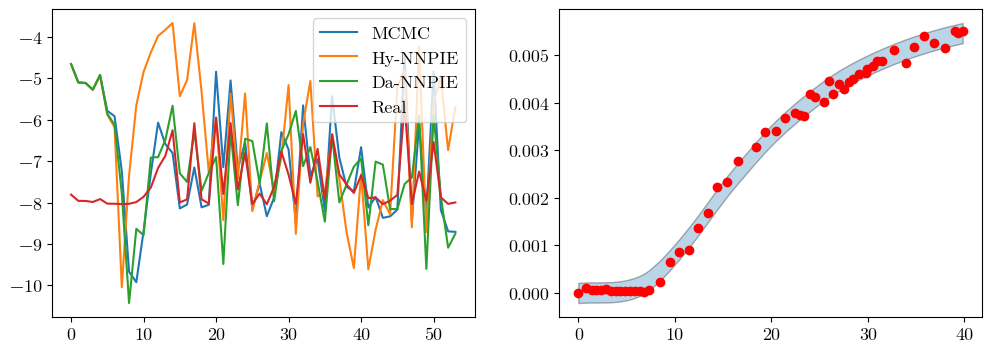

In [25]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 4))


nll_method = nll_estimation.nll_baseline

if (None, "Real") not in methods:
    methods.append((None, "Real"))

data = core2_data[1]
distributions = [
    stats.norm(loc=mean_core2_paper[i], scale=np.std(data - mean_core2_paper))
    for i in range(len(data))
]
# data = np.array([distr.rvs(size=1) for distr in distributions])
gauss_upper_90s = np.array([distr.ppf(0.95) for distr in distributions])
gauss_lower_90s = np.array([distr.ppf(0.05) for distr in distributions])

ax2.plot(core2_data[0], data, "ro")
ax2.fill_between(
    core2_data[0], gauss_lower_90s, gauss_upper_90s, alpha=0.3, edgecolor="k"
)

for method in methods:
    samples, name = method

    if name == "Paper MCMC":
        continue

    nlls = []
    for i in range(SKIP, len(data)):
        datapoint = np.array([data[i]])
        # print(name, i)
        if name == "Real":
            nlls.append(-distributions[i].logpdf(datapoint).squeeze())
        else:
            nlls.append(nll_method(samples.core2[:, i], datapoint).squeeze())
    nlls = np.array(nlls)

    print(f"{name:>10}: {nlls.mean()}")
    ax1.plot(nlls, label=name)

ax1.legend()
plt.show()

# Reliability curves

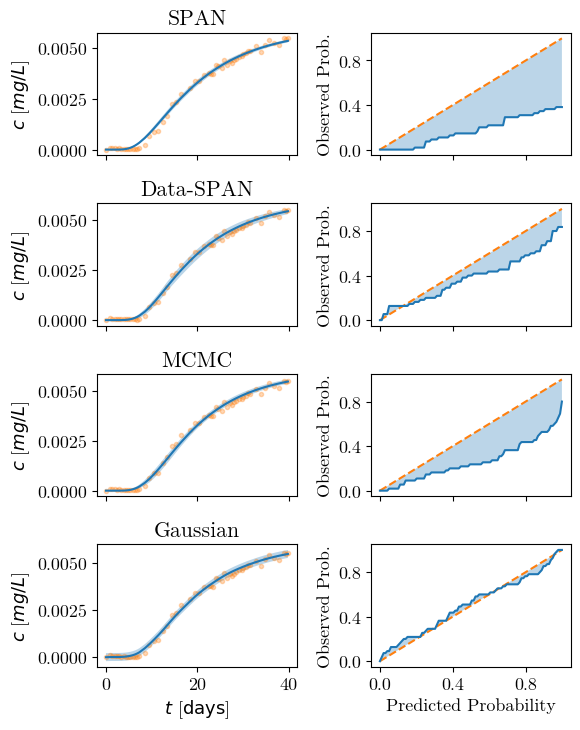

In [26]:
def reliability_curve(samples, weights, title: str, ylabel=True, axs=None, interval_fun=None):
    if not interval_fun:
        mean = samples.mean(axis=0)
    else:
        mean, _ = interval_fun(0.01)
    x = core2_data[0]
    y = core2_data[1]

    if axs is None:
        fig, axs = plt.subplots(nrows=2, figsize=(2*plotting.FIGURE_WIDTH, 2*plotting.FIGURE_HEIGHT))

    axs[0].set_title(title)
    FILL_PARAMS = dict(color="C0", alpha=0.3, edgecolor="none")
    axs[0].plot(x, y, ".", color="C1", alpha=0.3)
    axs[0].plot(x, mean, color="C0")
    if not interval_fun:
        axs[0].fill_between(
            x,
            *get_weighted_interval(samples, 0.9, weights),
            **FILL_PARAMS,
        )
    else:
        axs[0].fill_between(
            x,
            *interval_fun(0.9),
            **FILL_PARAMS,
        )


    calibration_curve_x = np.linspace(0, 0.999, 100, endpoint=True)
    calibration_curve_y = [0.0]
    for p in calibration_curve_x[1:]:
        if not interval_fun:
            lower, upper = get_weighted_interval(samples, p, weights)
        else:
            lower, upper = interval_fun(p)
        n_inside = np.count_nonzero((y < upper) & (y > lower))
        calibration_curve_y.append(n_inside / y.shape[0])

    optimal_calibration_curve_y = calibration_curve_x.copy()
    axs[1].plot(calibration_curve_x, optimal_calibration_curve_y, "--", color="C1")
    axs[1].plot(calibration_curve_x, calibration_curve_y, "-", color="C0")
    axs[1].fill_between(
        calibration_curve_x,
        optimal_calibration_curve_y,
        calibration_curve_y,
        **FILL_PARAMS,
    )
    axs[1].set_ylabel("Observed Prob.")
    if ylabel:
        axs[1].set_xlabel("Predicted Probability")

    return plt.gcf(), axs


# below identity -> overconfident
# above identity -> underconfident

def gaussian_interval_fun(p):
    lower = []
    upper = []
    for distr in distributions:
        lower.append(distr.ppf((1 - p)/2))
        upper.append(distr.ppf((1 + p)/2))
    return np.array(lower), np.array(upper)

fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(2*plotting.FIGURE_WIDTH, 4*plotting.FIGURE_HEIGHT), sharex="col")

for i, (samples, weights, title) in enumerate(
    [
        (span_samples.core2, span_weights, "SPAN"),
        (dataspan_samples.core2, dataspan_weights, "Data-SPAN"),
        (mcmc_samples.core2, None, "MCMC"),
        (None, None, "Gaussian"),
    ]
):
    reliability_curve(
        samples, weights, title, ylabel=True if i == 3 else False, axs=axs[i, :], interval_fun=None if samples is not None else gaussian_interval_fun
    )


import matplotlib.ticker as ticker

for i, ax in enumerate(axs[:, 0]):
    plotting.set_concentration_axes_stuff(ax, set_xlabel=i==3, set_ylabel=True)

for ax in axs[:, 1]:
    ax.xaxis.set_major_locator(ticker.MaxNLocator(3))
    ax.yaxis.set_major_locator(ticker.MaxNLocator(3))


plt.tight_layout()
plotting.savefig(fig, "../paper/figs/reliability_curves")
plt.show()

# Sensitiitivity Analysis

In [27]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

params_names = ["seed", "loss_phys_fac", "loss_mse_fac", "epoch"]


def sensitivity_analysis_from_samples(p_samples, y_samples):
    """
    Performs approximate sensitivity analysis using provided samples.

    Args:
        p_samples (numpy array): Array of shape (n_samples, n_params) representing parameter samples.
        y_samples (numpy array): Array of shape (n_samples, n_x) or (n_samples,) representing corresponding function output samples.

    Returns:
        pandas DataFrame: DataFrame containing approximate sensitivity indices for each parameter and each x
    """
    n_samples = p_samples.shape[0]
    n_params = p_samples.shape[1]
    if len(y_samples.shape) == 1:
        n_x = 1
    else:
        n_x = y_samples.shape[1]

    sensitivity_results = []

    # Scaling the data
    scaler_p = StandardScaler()
    p_scaled = scaler_p.fit_transform(p_samples)

    for i in range(n_x):
        if n_x == 1:
            y_i = y_samples
        else:
            y_i = y_samples[:, i]

        # Scale y
        scaler_y = StandardScaler()
        y_scaled = scaler_y.fit_transform(y_i.reshape(-1, 1)).flatten()
        # Linear regression for each x
        model = LinearRegression()
        model.fit(p_scaled, y_scaled)

        # Get coefficients of determination
        r2 = model.score(p_scaled, y_scaled)
        # Get coefficients of determination for each parameter individually:
        temp_results = []
        for j in range(n_params):
            temp_model = LinearRegression()
            temp_model.fit(p_scaled[:, j].reshape(-1, 1), y_scaled)
            temp_results.append(
                temp_model.score(p_scaled[:, j].reshape(-1, 1), y_scaled) / r2
            )
        sensitivity_results.append(temp_results)

    sensitivity_df = pd.DataFrame(
        sensitivity_results, columns=[params_names[i] for i in range(n_params)]
    )
    if n_x == 1:
        sensitivity_df["x"] = 0
    else:
        sensitivity_df["x"] = range(n_x)
    sensitivity_df = sensitivity_df.set_index("x")

    return sensitivity_df


# Example Usage
# Generate some random data for demonstration
import json

processed_expdata_dir = Path("../data_processed/experimental/SPAN")
p_samples = np.load(processed_expdata_dir / "params.npy", allow_pickle=False)
y_samples = np.load(processed_expdata_dir / "y_ret_samples.npy")[:, 250]
print(p_samples.shape)
print(y_samples.shape)


# Perform sensitivity analysis
sensitivity_df = sensitivity_analysis_from_samples(p_samples, y_samples)
print(sensitivity_df)

(780, 4)
(780,)
       seed  loss_phys_fac  loss_mse_fac     epoch
x                                                 
0  0.045123       0.003081      0.215141  0.352132


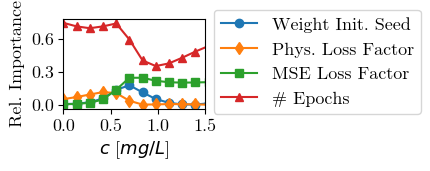

In [28]:
sensitivity_dfs = []
for i in range(0, np.load(processed_expdata_dir / "y_ret_samples.npy").shape[1], 35):
    y_samples = np.load(processed_expdata_dir / "y_ret_samples.npy")[:, i]
    df = sensitivity_analysis_from_samples(p_samples, y_samples)
    df["i"] = i
    sensitivity_dfs.append(df)

full_sensitivity_df = pd.concat(sensitivity_dfs, ignore_index=True)
full_sensitivity_df = full_sensitivity_df.rename(columns={"seed": "Weight Init. Seed", "loss_phys_fac": "Phys. Loss Factor", "loss_mse_fac": "MSE Loss Factor", "epoch": "# Epochs"})
# display(full_sensitivity_df)

ret_x = np.load(processed_expdata_dir / "x_ret_samples.npy")

fig, ax = plt.subplots(figsize=(1.5*plotting.FIGURE_WIDTH, plotting.FIGURE_HEIGHT))

for k, col in enumerate(full_sensitivity_df.columns):
    if col == "i":
        continue
    ax.plot(ret_x[full_sensitivity_df["i"]], full_sensitivity_df[col], "-", label=col, marker="ods^"[k])

ax.set_xlim(0, 1.5)
plotting.set_retardation_axes_stuff(ax, set_xlabel=True, set_ylabel=True)
ax.set_ylabel("Rel. Importance")
ax.legend(loc="upper left", bbox_to_anchor=(1,1.2))
plt.tight_layout()
plotting.savefig(fig, "../paper/figs/sensitivity")
plt.show()

# full_sensitivity_df[["seed", "loss_phys_fac", "loss_mse_fac", "epoch"]].to_numpy().mean(
#     axis=0
# )

  0%|          | 0/501 [00:00<?, ?it/s]/Users/r/.venvs/p3inn/lib/python3.11/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
100%|██████████| 501/501 [00:00<00:00, 700.84it/s]


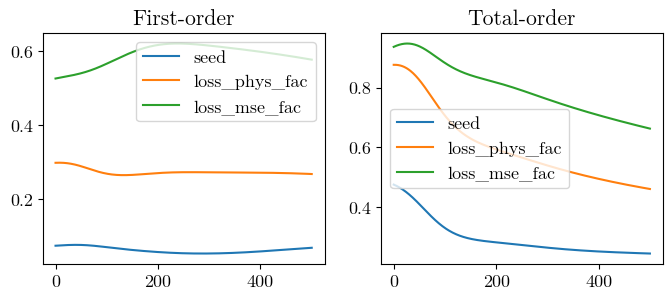

In [29]:
import tqdm
import numpy as np
import matplotlib.pyplot as plt
from SALib.analyze.sobol import analyze

processed_expdata_dir = Path("../data_processed/experimental/SPAN")
span_samples_ret = np.load(processed_expdata_dir / "y_ret_samples.npy")

problem = {
    "num_vars": 3,
    "names": ["seed", "loss_phys_fac", "loss_mse_fac"],
}

# Perform analysis
s1 = []  # first-order sensitivity indices
st = []  # total-order sensitivity indices

for i in tqdm.trange(span_samples_ret.shape[1]):
    Si = analyze(
        problem, span_samples_ret[:, i], print_to_console=False, calc_second_order=False
    )
    s1.append(Si["S1"])
    st.append(Si["ST"])
s1 = np.array(s1)
st = np.array(st)

fig, axs = plt.subplots(ncols=2, figsize=(8, 3))

axs[0].set_title("First-order")
for i in range(s1.shape[1]):
    axs[0].plot(s1[:, i], label=problem["names"][i])
axs[0].legend()

axs[1].set_title("Total-order")
for i in range(st.shape[1]):
    axs[1].plot(st[:, i], label=problem["names"][i])
axs[1].legend()

plt.show()